# Motivating example

I was thinking what happens if I have a really biased coin (say probability of tails = 0.95), but I want to estimate it. Ideally I'd run a large number of trials and estimate, but one is lazy, and I decide, I am going to run experiments till I hit the first tail, and then stop my experiments. How bad will that estimation be?

The following sections will be a very swift exploration of basic probability and estimation theory

# Geometric PDF
Lets say $P(X=head)=h$, clearly $P(X=tail)=1-h$

Probability of getting a head in $k$ tries is $P(X=k) = (1-h)^{k-1}h$





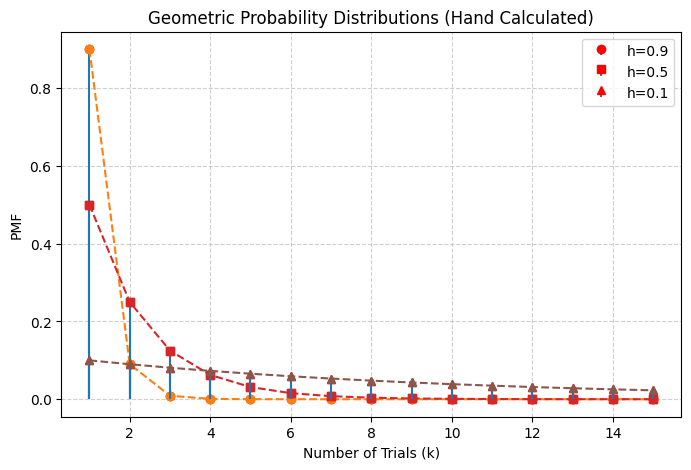

In [35]:
import numpy as np
import matplotlib.pyplot as plt
def plot_geometric_distributions():
    hs = [0.9, 0.5, 0.1]
    markers = ['o', 's', '^']  # Different markers for each value of h
    x = np.arange(1, 16)
    plt.figure(figsize=(8, 5))
    for h, marker in zip(hs, markers):
        pmf = (1 - h) ** (x - 1) * h
        plt.stem(x, pmf, label=f'h={h}', basefmt=" ", markerfmt=f'{marker}r')
        plt.plot(x, pmf, linestyle='--', marker=marker)  # Add a dotted line with markers
    plt.title('Geometric Probability Distributions (Hand Calculated)')
    plt.xlabel('Number of Trials (k)')
    plt.ylabel('PMF')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_geometric_distributions()

# Likelihood

## Setup
Let $K$ be a random variable, which takes values ${1,2, ...}$ indicating how many tries it takes us to hit a head

If I have an observation of $K=k$ tries before I hit a head, what is my estimate of $h$?

## Probability vs likelihood
Consider this probability $P(K=k ; h)$. But we have already observed that $K=k$. So likelihood is related to $P(K=k ; h)$, but its not quite the same thing. Instead think of it as a function of $h$ (for a given value of $K$) ie $f_{K=k}(h)$. And that happens to be $f_{K=k}(h) = P(K=k ; h) = (1-h)^{k-1}h$. Or, probability is a function of $k$ holding $h$ constant, and likelihood is a function of $h$ holding $k$ constant





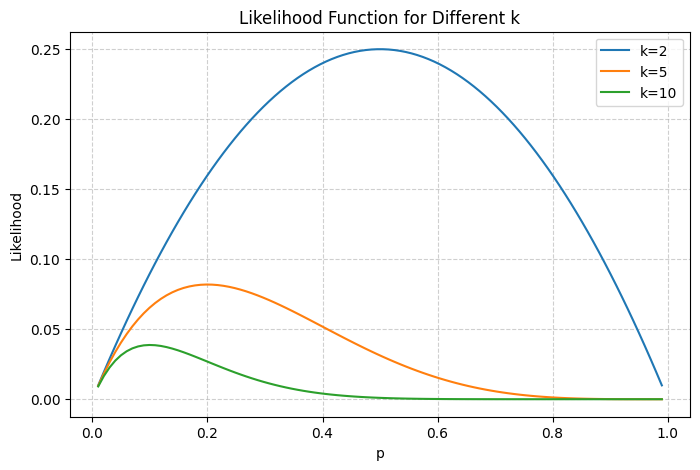

In [42]:
def likelihood_function_given_k(k, p):
    def likelihood(p):
        return (1 - p) ** (k - 1) * p
    return likelihood


hs = np.linspace(0.01, 0.99, 100)  # Avoid h=0 and h=1 to prevent division by zero
ks = [2, 5, 10]
plt.figure(figsize=(8, 5))
for k in ks:
    likelihood = likelihood_function_given_k(k, hs)
    plt.plot(hs, likelihood(hs), label=f'k={k}')
plt.title('Likelihood Function for Different k')
plt.xlabel('p')
plt.ylabel('Likelihood')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Maximize!
One good idea is to find $h$ that maximises likelihood (or the log of it, because that makes calculations easy sometimes and log is a monotonic increasing function)

If we differentiate and set it to 0, we get $h^{'}=1/k$. We add a "prime" to h to indicate its an estimate of the actual unknown $h$

This is the basic of "max likelihood estimation"

## How good is it?
Is it good estimate? For that we have to check bias.

So our estimate is a random variable, and if we repeated multiple experiments we would get different values of $K$. Bias is simply $E[H^{'}] - h$. $H^{'} = 1/K$. 

When $K=k$, $h^{'} = 1/k$ and the probability of that is $P(X=k) = (1-h)^{k-1}h$. Now vary $k$ from $[1, \inf)$


$E[P^{'} = 1/K] =  \sum_{k=1}^{\infty} h \frac{(1-h)^{k-1}}{k} 
= \frac{h}{1-h} \sum_{k=1}^{\infty} \frac{(1-h)^k}{k} 
= - \frac{h \ln h}{1-h}
$

So the bias is: $- \frac{h \ln h}{1-h} - h$

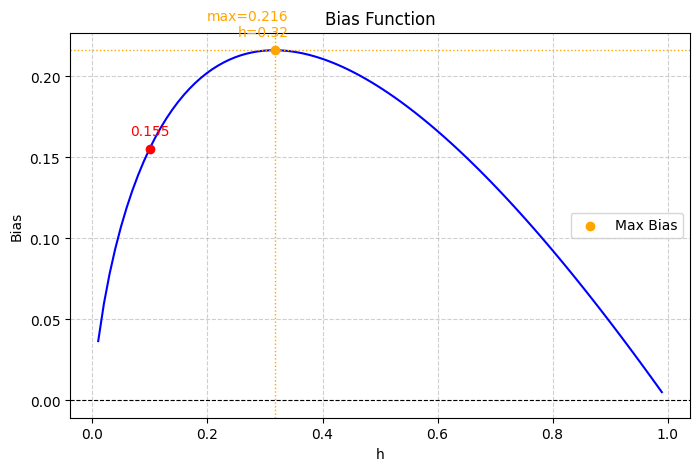

In [47]:
def plot_bias_function():
    h_values = np.linspace(0.01, 0.99, 100)  # Avoid h=0 and h=1 to prevent division by zero
    bias_values = -(h_values * np.log(h_values)) / (1 - h_values) - h_values

    plt.figure(figsize=(8, 5))
    plt.plot(h_values, bias_values, color='blue')
    plt.title('Bias Function')
    plt.xlabel('h')
    plt.ylabel('Bias')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Annotate the bias value at h=0.1
    h_annotate = 0.1
    idx = np.abs(h_values - h_annotate).argmin()
    bias_at_01 = bias_values[idx]
    plt.scatter([h_annotate], [bias_at_01], color='red', zorder=5)
    plt.annotate(f"{bias_at_01:.3f}", (h_annotate, bias_at_01), textcoords="offset points", xytext=(0,10), ha='center', color='red')

    # Mark the maximum point
    max_idx = np.argmax(bias_values)
    h_max = h_values[max_idx]
    bias_max = bias_values[max_idx]
    plt.scatter([h_max], [bias_max], color='orange', zorder=6, label='Max Bias')
    plt.axvline(h_max, color='orange', linestyle=':', linewidth=1)
    plt.axhline(bias_max, color='orange', linestyle=':', linewidth=1)
    plt.annotate(f"max={bias_max:.3f}\nh={h_max:.2f}", (h_max, bias_max), textcoords="offset points", xytext=(10,10), ha='right', color='orange')

    plt.legend()
    plt.show()

plot_bias_function()

Note that if $h$ is very small or very big, we can get away with it. And if we find the max value for this bias curve, we see for $h \approx 0.32$ we get the worst estimates. But remember, in our original problem statement we know its a very biased coin, and we are asking if we can get away with doing a single-head estimation. Seems we can!

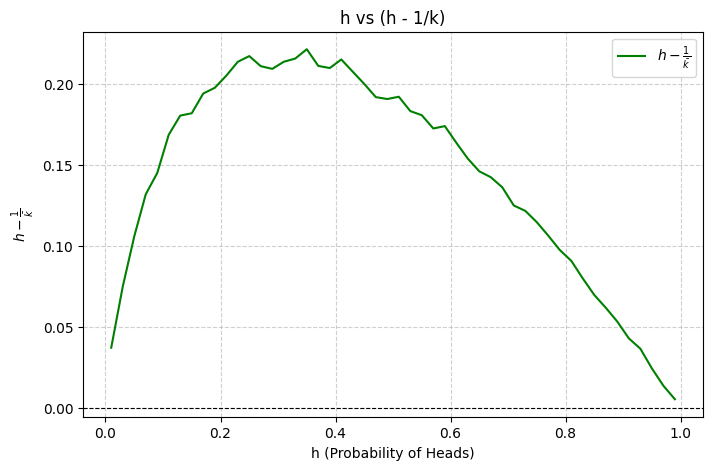

In [38]:
def simulate_and_plot_h_vs_bias(num_simulations=10000):
    h_values = np.linspace(0.01, 0.99, 50)  # Avoid h=0 and h=1 to prevent infinite loops
    biases = []

    for h in h_values:
        k_trials = []
        for _ in range(num_simulations):
            k = 1
            while np.random.rand() > h:  # Simulate coin tosses
                k += 1
            k_trials.append(k)
        bias = np.mean(1/np.array(k_trials)) - h
        biases.append(bias)

    plt.figure(figsize=(8, 5))
    plt.plot(h_values, biases, label=r'$h - \frac{1}{\bar{k}}$', color='green')
    plt.title('h vs (h - 1/k)')
    plt.xlabel('h (Probability of Heads)')
    plt.ylabel(r'$h - \frac{1}{\bar{k}}$')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

simulate_and_plot_h_vs_bias()

But can we really get away with it? In absolute terms, yes the bias is low, but in relative terms it can be quite large:

$(- \frac{h \ln h}{1-h} - h) / h$, which is $\frac{h- \ln h - 1}{1-h}$



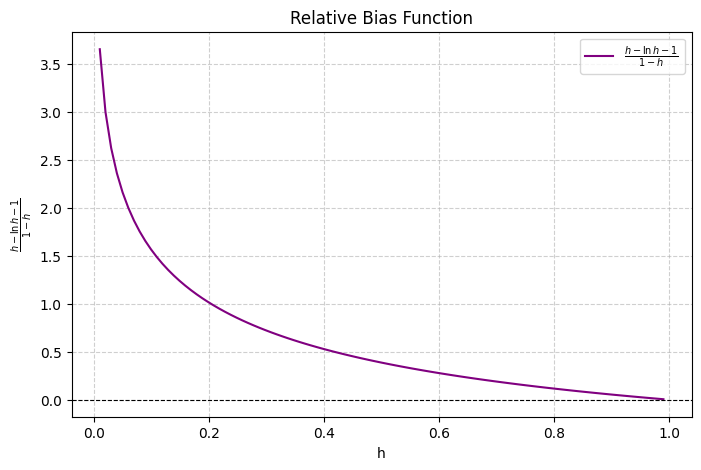

In [39]:
# Calculate the relative bias function
hs = np.linspace(0.01, 0.99, 100)
relative_bias = (hs - np.log(hs) - 1) / (1 - hs)

# Plot the relative bias function
plt.figure(figsize=(8, 5))
plt.plot(hs, relative_bias, label=r'$\frac{h - \ln h - 1}{1-h}$', color='purple')
plt.title('Relative Bias Function')
plt.xlabel('h')
plt.ylabel(r'$\frac{h - \ln h - 1}{1-h}$')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## A better estimator
Now a much better estimator would be to run multiple experiments of coin tosses and count the number of times it takes to hit a head, but remember the original motivating problem, its a really biased coin, and we are lazy, and trying to get away with as less coin flips as possible, sigh. But you can read all about this better estimator in any standard estimation theory book


# Another framing, Bayesian

In the last section, note I wrote $P(K=k ; h)$, and not $P(K=k | h)$ to explicitly mean h is not a random variable, so its not conditioning, its just the PDF is a function/dependent on $h$

But what if we consider it to be a random variable?

Then we are trying to estimate a random variable $H$ which is probability of heads which is a continuous RV that takes values $[0,1]$

Because we dont know anything about it, we assume $H = h  \sim  Uniform(0,1)$. We call this the prior. In a real-world usecase we could set this to be high around 0.5

Unlike the maximizing approach, here we try to (very sensibly) compute $E[H | K=k]$

Likelihood function is $f_{H|K}(h|k) \propto f_{K|H}(k|h)f_H(h)$

$f_{K|H}(k|h) = (1-h)^{k-1}h$ and by uniform pdf assumption $f_H(h)=1$

This happens to $Beta(2,k)$ distribution, which has a mean of $\frac{2}{k+2}$

## Injecting the "low-heads-probability" prior information

But wait, we started with the assumption that it was a biased low-heads-probability coin. So lets add that as our prior

Given the beta-ness of the distribution, lets choose another beta distribution (say $Beta(1,9)$). This has a mean of $1/(1+9)=0.1$, which is in the low $h$ regime. Thus $f_H(h) \propto h^0(1-h)^8$

Putting the prior and likelihood together:
$f_{H|K}(h|k) \propto h(1-h)^{k-1}(1-h)^8=h(1-h)^{k+7}$
which is $Beta(2, k+8)$

This has a mean of $2/(2+k+8) = 2/(k+10)$

If we computed in general we would get $\frac{\alpha + 1}{\alpha + \beta + k}$

Lets plot the 3 different estimates of $h$:

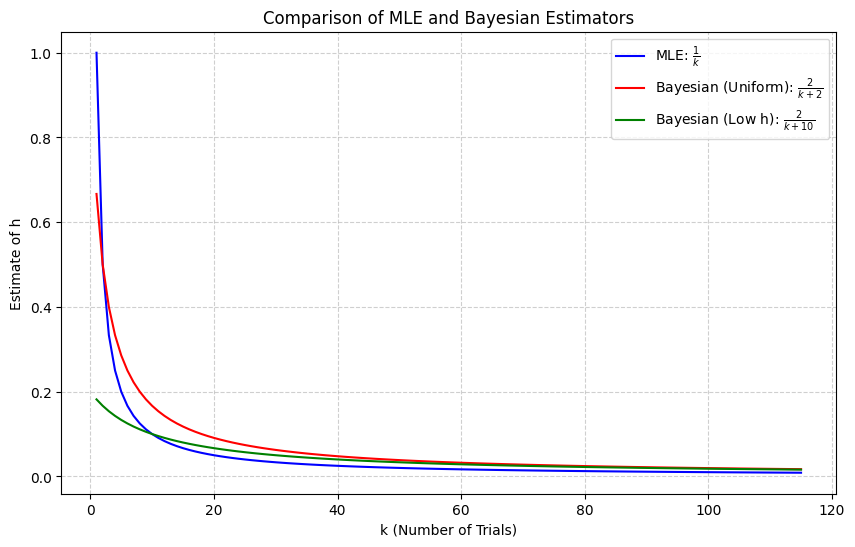

In [40]:
k_values = np.arange(1, 116)
mle_estimate = 1 / k_values
bayesian_estimate_uniform = 2 / (k_values + 2)
bayesian_estimate_lowh = 2 / (k_values + 10)

plt.figure(figsize=(10, 6))
plt.plot(k_values, mle_estimate, label=r'MLE: $\frac{1}{k}$', color='blue')
plt.plot(k_values, bayesian_estimate_uniform, label=r'Bayesian (Uniform): $\frac{2}{k+2}$', color='red')
plt.plot(k_values, bayesian_estimate_lowh, label=r'Bayesian (Low h): $\frac{2}{k+10}$', color='green')
plt.title('Comparison of MLE and Bayesian Estimators')
plt.xlabel('k (Number of Trials)')
plt.ylabel('Estimate of h')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## How good is it, (or the bias)

### Uniform prior
Bias is calculated as $E_h[H^{'}(K)] - h$ which is $(\sum_{k=1}^{\infty}{\frac{2}{k+2}h(1-h)^{k-1}}) - h$



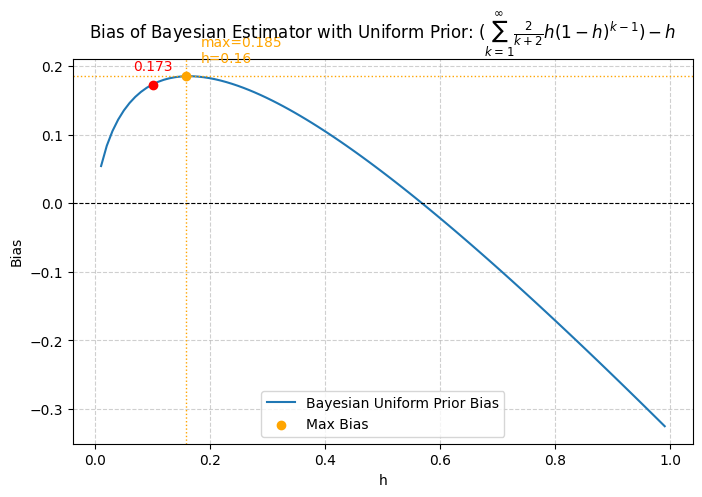

In [50]:
def bayesian_uniform_bias(h):
    k_max = 1000
    k = np.arange(1, k_max + 1)
    terms = (2 / (k + 2)) * h * (1 - h) ** (k - 1)
    return np.sum(terms) - h

h_values = np.linspace(0.01, 0.99, 100)
biases = [bayesian_uniform_bias(h) for h in h_values]

plt.figure(figsize=(8, 5))
plt.plot(h_values, biases, label='Bayesian Uniform Prior Bias')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('h')
plt.ylabel('Bias')
plt.title(r'Bias of Bayesian Estimator with Uniform Prior: $(\sum_{k=1}^{\infty}{\frac{2}{k+2}h(1-h)^{k-1}}) - h$')
plt.grid(True, linestyle='--', alpha=0.6)

# Mark h=0.1 with its value
h_annotate = 0.1
idx = np.abs(h_values - h_annotate).argmin()
bias_at_01 = biases[idx]
plt.scatter([h_annotate], [bias_at_01], color='red', zorder=5)
plt.annotate(f"{bias_at_01:.3f}", (h_annotate, bias_at_01), textcoords="offset points", xytext=(0,10), ha='center', color='red')

# Find the maximum bias and its corresponding h value
max_idx = np.argmax(biases)
h_max = h_values[max_idx]
bias_max = biases[max_idx]
plt.scatter([h_max], [bias_max], color='orange', zorder=6, label='Max Bias')
plt.axvline(h_max, color='orange', linestyle=':', linewidth=1)
plt.axhline(bias_max, color='orange', linestyle=':', linewidth=1)
plt.annotate(f"max={bias_max:.3f}\nh={h_max:.2f}", (h_max, bias_max), textcoords="offset points", xytext=(10,10), ha='left', color='orange')

plt.legend()
plt.show()

### Low head probability h prior


For prior $H ~ Beta(\alpha, \beta)$, estimated heads prob is a RV $H^{'}(K) = E[H | K] = \frac{\alpha + 1}{\alpha + \beta + K}$.

And, of course, when the RV $K$ happens to take value $k$ we get a concrete estimate $\frac{\alpha + 1}{\alpha + \beta + k}$

Bias of this is calculated as $E[H^{'}(K)] - h$, where this expectation is calculated over the RV $K$, the number of observed trials before a head

$$
E[H^{'}(K)] = \sum_{k=1}^{\infty} H^{'}(k) P(K=k \mid h)
= \sum_{k=1}^{\infty} \frac{\alpha + 1}{ \alpha + \beta + k} \, h (1-h)^{k-1}.
$$

So bias is:
$(\sum_{k=1}^{\infty} \frac{\alpha + 1}{ \alpha + \beta + k} \, h (1-h)^{k-1}) - h$

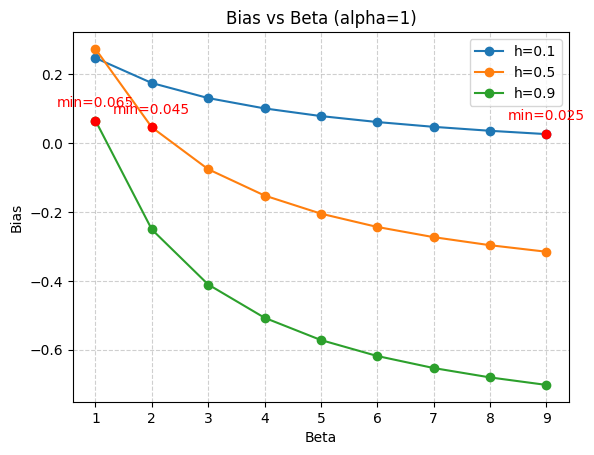

In [69]:
import numpy as np

def bias_fn_given_h(h):
    def bias_fn(alpha, beta):
        bias = (alpha+1)*h * sum([(1-h)**n / (n+alpha+beta) for n in range(1000)]) - h
        return bias
    return bias_fn

hs = [0.1, 0.5, 0.9]
betas = range(1, 10)
for h in hs:
    biases = [bias_fn_given_h(h)(1, beta) for beta in betas]
    plt.plot(betas, biases, marker='o', label=f'h={h}')
    min_idx = np.argmin(np.abs(biases))
    plt.scatter(betas[min_idx], biases[min_idx], color='red', zorder=5)
    plt.annotate(f"min={biases[min_idx]:.3f}", (betas[min_idx], biases[min_idx]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.title('Bias vs Beta (alpha=1)')
plt.xlabel('Beta')
plt.ylabel('Bias')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

For a specific prior say $Beta(1,9)$ lets plot its bias

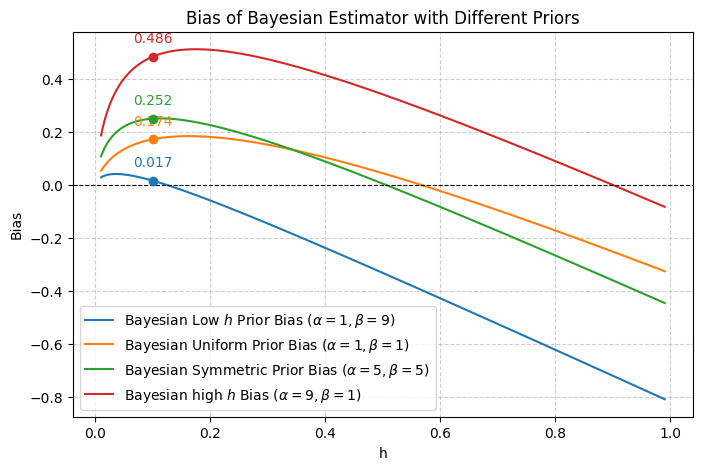

In [75]:
def get_bias_fn_given_alpha_beta(alpha, beta):
    def bias_fn(h):
        bias = (alpha + 1) * h * sum([(1 - h) ** (n-1) / (n + alpha + beta) for n in range(1, 1000)]) - h
        return bias
    return bias_fn

plt.figure(figsize=(8, 5))
priors = [
    (1, 9, r'Bayesian Low $h$ Prior Bias ($\alpha=1, \beta=9$)', 'tab:blue'),
    (1, 1, r'Bayesian Uniform Prior Bias ($\alpha=1, \beta=1$)', 'tab:orange'),
    (5, 5, r'Bayesian Symmetric Prior Bias ($\alpha=5, \beta=5$)', 'tab:green'),
    (9, 1, r'Bayesian high $h$ Bias ($\alpha=9, \beta=1$)', 'tab:red')
]
for alpha, beta, label, color in priors:
    bias_fn = get_bias_fn_given_alpha_beta(alpha, beta)
    h_values = np.linspace(0.01, 0.99, 1000)
    biases = [bias_fn(h) for h in h_values]
    plt.plot(h_values, biases, label=label, color=color)
    # Annotate the bias value at h=0.1
    idx = np.abs(h_values - 0.1).argmin()
    bias_at_01 = biases[idx]
    plt.scatter([0.1], [bias_at_01], zorder=5, color=color)
    plt.annotate(f"{bias_at_01:.3f}", (0.1, bias_at_01), textcoords="offset points", xytext=(0,10), ha='center', color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('h')
plt.ylabel('Bias')
plt.title('Bias of Bayesian Estimator with Different Priors')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


For MLE we got a bias of 0.155, while for Bayesian estimator with a good prior we got a much lower value 0.025. However if we chose a wrong prior (low h prior like $\beta(1,9)$) when the actual h is higher like 0.5 or 0.9, we get a very biased result. Similarly if we choose a high h prior like $\beta(9,1)$ when the actual h is low, we get high bias (0.526).


If actual probability of heads is $h=0.1$, here is a table over expected bias

| method | estimator | bias | comments |
|----------|----------|----------|----------|
| MLE        | $1/k$ | 0.155        | -        |
| Bayesian with uniform prior    | $2/(k+2)$    | 0.173        | About the same as MLE. But it is a weighted avg between frequentist MLE and prior 0.5, so it overestimates giving a larger bias for $h=0.1$        |
| Bayesian with $\beta(1,1)$ uniform prior  | $2/(k+2)$      | 0.173        | $\beta(1,1)$ is uniform        |
| Bayesian with $\beta(5,5)$ centered h prior   | $6/(k+10)$      | 0.276        | prior is centered around 0.5 (fair coin)        |
| Bayesian with $\beta(1,9)$ low h prior  | $2/(k+10)$      | 0.026        | low h prior, best bias due to correct prior        |
| Bayesian with $\beta(9,1)$ high h prior  | $10/(k+10)$      | 0.526        | high h prior, worst bias because of wrong prior        |




In [66]:

def simulate_biases(num_simulations=1000000, h=0.1):
    mle_biases = []
    bayes_uniform_biases = []
    bayes_centered_biases = []
    bayes_lowh_biases = []
    bayes_highh_biases = []
    for _ in range(num_simulations):
        k = 1
        while np.random.rand() > h:
            k += 1
        mle_est = 1 / k
        bayes_uniform_est = 2 / (k + 2)
        bayes_centered_est = 6 / (k + 10)
        bayes_highh_est = 10 / (k + 10)
        bayes_lowh_est = 2 / (k + 10)
        bayes_lowh_biases.append(bayes_lowh_est - h)
        mle_biases.append(mle_est - h)
        bayes_uniform_biases.append(bayes_uniform_est - h)
        bayes_centered_biases.append(bayes_centered_est - h)
        bayes_highh_biases.append(bayes_highh_est - h)
    return {
        'MLE': np.mean(mle_biases),
        'Bayesian Uniform': np.mean(bayes_uniform_biases),
        'Bayesian Centered': np.mean(bayes_centered_biases),
        'Bayesian High h': np.mean(bayes_highh_biases),
        'Bayesian Low h': np.mean(bayes_lowh_biases)
    }

bias_results = simulate_biases()
for method, bias in bias_results.items():
    print(f"{method:20s}: {bias:.5f}")

MLE                 : 0.15625
Bayesian Uniform    : 0.17400
Bayesian Centered   : 0.25174
Bayesian High h     : 0.48623
Bayesian Low h      : 0.01725


# Conclusion

So if you want to be lazy and do few experiments to measure your low heads probability coin, MLE might not cut it. You need to inform your estimator of your prior, and then you can be lazy